# SVD++

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 

In [0]:
def implicit_neighbours_movies(R, u):
    """ Calculate set of movies for which user u provided an implicit preference.

    Note:
        Apparently, for the netflix data implicit set is equal to 
        the explicit set.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.

    Returns: 
    (1-D np.array): Set of movies for which ratings by user u are available.
    """

    return [i for i in range(R.shape[1]) if R[u, i]]

In [0]:
def gradient_J(R, f, B_i, B_u, mu, P, Q, Y, lambda_5):
    """Calculate stochastic gradient descent for the correlation
    Based Implicit Neighbourhood model.

    Parameters:
        R (coo_matrix): Rating matrix.
        f (int): Number of latent factors.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        P (2-D np.array): Parameter that describes user u in terms 
                          of his belonging to f user categories.
        Q (2-D np.array): Parameter that represent for the movie i
                          the proportions of f genres that it contains.
        Y (2-D np.array): Parameter that representes each user u 
                          by the factor vector. 
        lambda_5 (float): Penality coefficient.

    Returns:
        b_i (1-D np.array): Gradient of observed deviation for each movie.
        b_u (1-D np.array): Gradient of observed deviation for each user.
        p (2-D np.array): Gradient of the parameter that describes user u 
                          in terms of his belonging to f user categories.
        q (2-D np.array): Gradient of the parameter that represent for the 
                          movie i the proportions of f genres that it contains.
        y (2-D np.array): Gradient of the parameter that representes each 
                          user u by the factor vector. 

    """

    users, items = R.nonzero()
    b_u, b_i =  np.zeros(len(B_u)), np.zeros(len(B_i))
    p, q =  np.zeros((len(P), f)), np.zeros((len(Q), f))
    y = np.zeros((len(Y), f))

    for u, i in zip(users, items):
        N_u = implicit_neighbours_movies(R, u)

        y_sum = np.zeros(f)
        for j in N_u:
            for d in range(f):
                y_sum[d] += Y[j, d] / np.sqrt(len(N_u))
                
        e = R[u, i] - (mu + B_u[u] + B_i[i] + \
                       sum([Q[i, d] * (P[u, d] + y_sum[d]) for d in range(f)]))

        b_u[u] += e - lambda_5*B_u[u]
        b_i[i] += e - lambda_5*B_i[i]

        for d in range(f):
            p[u, d] += Q[i, d]*e - lambda_5*P[u, d]

            q[i, d] += (P[u, d] + y_sum[d])*e - lambda_5*Q[i, d]

            for j in N_u:
                y[j, d] += Q[i, d]*e/np.sqrt(len(N_u)) - lambda_5*Y[j, d]

        
    return -2*b_i, -2*b_u, -2*p, -2*q, -2*y

In [0]:
def rmse(R, B_i, B_u, mu, P, Q, Y):
    """Calculate the root-mean-square deviation using the
       estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        P (2-D np.array): Parameter that describes user u in terms 
                          of his belonging to f user categories.
        Q (2-D np.array): Parameter that represent for the movie i
                          the proportions of f genres that it contains.
        Y (2-D np.array): Parameter that representes each user u 
                          by the factor vector. 

    Returns:
        error (float): RMSE error value.

    """

    users, items = R.nonzero()
    error = 0
    for u, i in zip(users, items):
        N_u = implicit_neighbours_movies(R, u)
        
        r = mu + B_u[u] + B_i[i] + np.dot((P[u, :] + sum([Y[j, :] for j in N_u])*\
                                           (1/np.sqrt(len(N_u)))), Q[i, :].T)
        error += pow(R[u, i] - r, 2)
    error = (1 / R.shape[0]) * error

    return error

In [0]:
def recreate_matrix(R, B_i, B_u, mu, P, Q, Y):
    """Recreate the matrix using estimated parameters.

    Parameters:
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        P (2-D np.array): Parameter that describes user u in terms 
                          of his belonging to f user categories.
        Q (2-D np.array): Parameter that represent for the movie i
                          the proportions of f genres that it contains.
        Y (2-D np.array): Parameter that representes each user u 
                          by the factor vector. 

    Returns:
        R_estimated (2-D np.array): Recreated rating matrix.

    """

    R = R.tocsr()
    R_estimated = np.zeros((len(B_u), len(B_i)))

    for u in range(len(B_u)):
        for i in range(len(B_i)):
            
            N_u = implicit_neighbours_movies(R, u)
            R_estimated[u, i] = mu + B_u[u] + B_i[i] + \
                                np.dot((P[u, :] + sum([Y[j, :] for j in N_u])*\
                                (1/np.sqrt(len(N_u)))), Q[i, :].T)

    return R_estimated

In [0]:
def SVD_plus_plus(R, f, N, delta=0.01, lambda_5=0.02, verbose=False, plot=True):
    """Estimate SVD++ model parameters using SGD.

    Parameters:
        R (coo_matrix): Rating matrix.
        f (int): Number of latent factors.
        N (int): Number of iterations.
        delta (float): Learning rate.
        lambda_5 (float): Penality coefficient.
        plot (boolean): Plot RMSE track if True.
        verbose (boolean): Print number of the current iteration at excecution.

    Returns:
        B_i_opt (1-D np.array): Optimal observed deviation for each movie.
        B_u_opt (1-D np.array): Optimal observed deviation for each user.
        P_opt (2-D np.array): Optimal value of the parameter that describes user
                              u in terms of his belonging to f user categories.
        Q_opt (2-D np.array): Optimal value of the parameter that represent for
                              the movie i the proportions of f genres that 
                              it contains.
        Y_opt (2-D np.array): Optimal value of the parameter that representes 
                              each user u by the factor vector. 

    """

    # Weight initialization
    B_u = 0 * np.random.rand(R.shape[0])
    B_i = 0 * np.random.rand(R.shape[1])
    P_u = 0 * np.random.rand(R.shape[0], f)
    Q_i = 0 * np.random.rand(R.shape[1], f)
    Y_j = 0 * np.random.rand(R.shape[0], f)

    # Logs initialization
    mse_track = np.zeros(N) 
    w_track = []

    # Calculate overall average rating value
    mu = R.data.mean()

    # Convert R into a csr_matrix
    R = R.tocsr()

    # SDG on N iterations
    for i in range(N):
        if verbose:
            print("Iteration "+ str(i))
        
        # Calculate SGD 
        gradient = gradient_J(R, f, B_i, B_u, mu, P_u, Q_i, Y_j, lambda_5)
        B_i = B_i - delta * gradient[0] 
        B_u = B_u - delta * gradient[1]
        P_u = P_u - delta * gradient[2]
        Q_i = Q_i - delta * gradient[3]
        Y_j = Y_j - delta * gradient[4]

        # Saving RMSE values
        mse_track[i] = rmse(R, B_i, B_u, mu, P_u, Q_i, Y_j)
        
        # Saving estimated parameters
        w_track.append([B_i, B_u, P_u, Q_i, Y_j])

        #if i>0 and pow(mse_track[i] - mse_track[i-1], 2) < pow(10, -6): break

    # Selecting the optimal parameters
    idx_min = np.argmin(mse_track)
    B_i_opt = w_track[idx_min][0]
    B_u_opt = w_track[idx_min][1]
    P_u_opt = w_track[idx_min][2]
    Q_i_opt = w_track[idx_min][3]
    Y_j_opt = w_track[idx_min][4]

    # Ploting RMSE deviation if plot is True
    if plot:
        mse_track = np.array([float(round(mse,3)) for mse in mse_track])
        plt.figure(figsize = (20,8))
        plt.rcParams['axes.facecolor'] = 'orange'
        plt.grid(c='white')
        plt.plot(np.arange(0,N), mse_track, 'blue')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Minimum MSE = {:.4f} reached at iteration {}'.format(min(mse_track),idx_min+1), fontsize = 15)
        plt.axvline(x = idx_min, color = 'green')

    return B_i_opt, B_u_opt, P_u_opt, Q_i_opt, Y_j_opt

# Dump example

In [0]:
from scipy.sparse import coo_matrix
R = coo_matrix(np.array([
                [0, 3, 0, 4, 0, 5, 2],
                [1, 0, 0, 2, 1, 2, 0],
                [5, 2, 4, 5, 0, 0, 3],
                [3, 0, 0, 3, 5, 5, 1],
                [1, 0, 5, 0, 1, 1, 0],
                [2, 4, 1, 4, 2, 3, 0],
                [0, 0, 0, 2, 0, 0, 4],
                [1, 4, 4, 3, 3, 0, 2]]
))

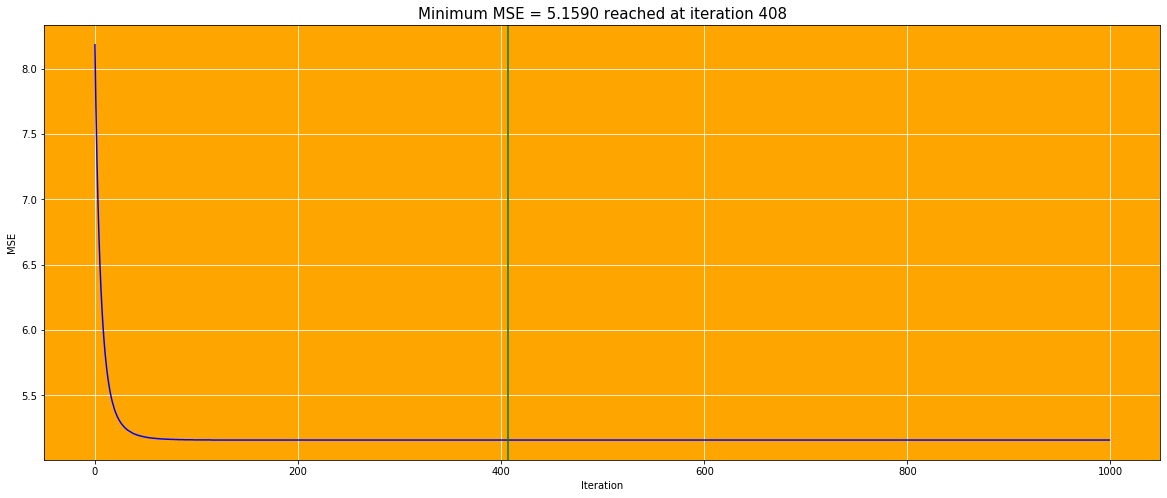

In [8]:
# Estimate SVD++ model parameters using SGD.

B_i_opt, B_u_opt, P_u_opt, Q_i_opt, Y_j_opt = SVD_plus_plus(R, f=3, N=1000, delta=0.01, lambda_5=0.02, plot=True)

In [13]:
# Recreate an estimated matrix using SVD++ model parameters.

recreate_matrix(R, B_i_opt, B_u_opt, R.data.mean(), P_u_opt, Q_i_opt, Y_j_opt)

array([[3.00394627, 3.55557738, 4.21367131, 3.76845403, 3.46826389,
        4.13808772, 2.48695491],
       [0.93784853, 1.48947965, 2.14757358, 1.70235629, 1.40216615,
        2.07198998, 0.42085717],
       [3.37799321, 3.92962432, 4.58771826, 4.14250097, 3.84231083,
        4.51213466, 2.86100185],
       [3.01777685, 3.56940796, 4.22750189, 3.78228461, 3.48209447,
        4.1519183 , 2.50078549],
       [1.31892292, 1.87055404, 2.52864797, 2.08343068, 1.78324054,
        2.45306438, 0.80193156],
       [1.98685681, 2.53848793, 3.19658186, 2.75136457, 2.45117443,
        3.12099826, 1.46986545],
       [2.86636296, 3.41799408, 4.07608801, 3.63087072, 3.33068058,
        4.00050442, 2.3493716 ],
       [2.42004846, 2.97167958, 3.62977351, 3.18455623, 2.88436608,
        3.55418992, 1.9030571 ]])

In [0]:
R.toarray()

array([[0, 3, 0, 4, 0, 5, 2],
       [1, 0, 0, 2, 1, 2, 0],
       [5, 2, 4, 5, 0, 0, 3],
       [3, 0, 0, 3, 5, 5, 1],
       [1, 0, 5, 0, 1, 1, 0],
       [2, 4, 1, 4, 2, 3, 0],
       [0, 0, 0, 2, 0, 0, 4],
       [1, 4, 4, 3, 3, 0, 2]], dtype=int64)

# Real application

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***L'execution de cette partie prend beaucoup de temps sur Colab !***

In [0]:
from scipy.sparse import save_npz, load_npz, coo_matrix

def load_matrix(M_name):
    """ Load previously saved sparce matrix M.

    Parameters:
        M_name (string): Matrix name as saved in drive (R, T or D).

    Returns:
        M (coo_matrix): Saved matrix.

    """

    M = load_npz("/content/drive/My Drive/Factorisation matricielle - dataset/training_set_csv/"+M_name+".npz")

    return M

In [0]:
# Loading R matrix

R = load_matrix("R")

In [0]:
import datetime
start = datetime.datetime.now()

B_i_opt, B_u_opt, P_u_opt, Q_i_opt, Y_j_opt = SVD_plus_plus(T, f=6, N=500, delta=0.01, lambda_5=0.02, plot=True)

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))

Iteration 0


In [0]:
import datetime
start = datetime.datetime.now()

R_estimate = recreate_matrix(B_i_opt, B_u_opt, mu=R.data.mean())

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))